# Models
(arranjar um nome melhor para o notebook)

Notebook para o treinamento de modelos

In [109]:
import random
import pickle

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models
import sklearn
import sktime
import keras
import statsmodels.api as sm
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from tensorflow import keras
from tensorflow.keras import layers

# model selection and metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

# constants
PROCESSED_DATA_PATH = '../data/processed-data/'
MODEL_PATH = '../models/trained-models/'
TARGET_COLS = ['target1', 'target2', 'target3', 'target4']
TEST_SPLIT_DATE = '2021-04-30'

# disable warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Auxiliary Functions

In [110]:
def plot_time_series(df, groupby = 'median', cols = TARGET_COLS):
    df_melted = df.groupby('Dt').median()[cols]\
    .melt(var_name='target', value_name='value', ignore_index=False)
    df_melted.reset_index(inplace=True)

    sns.set(rc={'figure.figsize':(10,20)})
    sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
    .map(sns.lineplot, 'Dt', 'value');

In [3]:
def plot_train_test_pred(train, test, pred = pd.DataFrame(), groupby = 'median', cols = TARGET_COLS):
    train['type'] = 'train'
    test['type'] = 'test'
    pred['type'] = 'pred'
    
    cols.append('type')

    df = pd.concat([train, test, pred], axis=0)
    df_melted = df.groupby('Dt').median()[cols]\
        .melt(var_name='target', value_name='value', ignore_index=False)
    df_melted.reset_index(inplace=True)
    
    sns.set(rc={'figure.figsize':(10,20)})
    sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
        .map(sns.lineplot, 'Dt', 'value', hue='type');

## Data Preparation

Apenas realizar modificações necessárias para os modelos como *splitting* dos datasets e normalização. Toda a limpeza de dados deve ser feita em **/src/data-engineering/data-preparation**

### Loading the data

In [4]:
%%time
# df_targets = pd.read_pickle(PROCESSED_DATA_PATH + 'targets.pkl')

CPU times: user 197 ms, sys: 98.6 ms, total: 296 ms
Wall time: 296 ms


In [5]:
# df_targets

,Dt,IdPlayer,target1,target2,target3,target4,IdDtPlayer
0,2018-01-01,628317,0.011167,4.474708,0.005168,5.735294,2018-01-01 00:00:00_628317
1,2018-01-01,547989,0.042993,5.593385,0.045033,2.794118,2018-01-01 00:00:00_547989
2,2018-01-01,519317,0.974327,56.177044,13.693746,64.166664,2018-01-01 00:00:00_519317
3,2018-01-01,607625,0.006700,2.675097,0.005168,1.862745,2018-01-01 00:00:00_607625
4,2018-01-01,592547,0.001117,0.632296,0.002953,0.931373,2018-01-01 00:00:00_592547
...,...,...,...,...,...,...,...
2695783,2021-07-31,527055,0.000000,0.027442,0.000000,0.157926,2021-07-31 00:00:00_527055
2695784,2021-07-31,542963,0.000834,0.137212,0.000000,0.146908,2021-07-31 00:00:00_542963
2695785,2021-07-31,622259,0.000119,0.102909,0.000000,0.058763,2021-07-31 00:00:00_622259
2695786,2021-07-31,642840,0.000119,0.048024,0.000000,0.036727,2021-07-31 00:00:00_642840


### Sorting by IdPlayer

In [6]:
# # sort by player then by date
# df_targets.sort_values(by=['IdPlayer', 'Dt'], inplace=True)
# # reset index
# df_targets.reset_index(drop=True, inplace=True)
# df_targets

,Dt,IdPlayer,target1,target2,target3,target4,IdDtPlayer
0,2018-01-01,112526,0.055277,5.496109,0.025839,16.176470,2018-01-01 00:00:00_112526
1,2018-01-02,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02 00:00:00_112526
2,2018-01-03,112526,0.029341,1.648352,0.032613,10.490111,2018-01-03 00:00:00_112526
3,2018-01-04,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04 00:00:00_112526
4,2018-01-05,112526,0.083916,1.161002,0.024759,6.643879,2018-01-05 00:00:00_112526
...,...,...,...,...,...,...,...
2695783,2021-07-27,685503,0.000642,0.182785,0.000482,0.574713,2021-07-27 00:00:00_685503
2695784,2021-07-28,685503,0.000515,0.144995,0.000681,0.068164,2021-07-28 00:00:00_685503
2695785,2021-07-29,685503,0.000536,0.139173,0.000389,0.079939,2021-07-29 00:00:00_685503
2695786,2021-07-30,685503,0.000452,0.193631,0.002074,0.217098,2021-07-30 00:00:00_685503


In [7]:
# Example dataset
# df_targets = df_targets[df_targets['IdPlayer'].isin([112526, 685503, 628317])]
# df_targets

### Shifting

In [8]:
# %%time
# # Make the shifts for each target
# shift_vals = [1, 2, 3, 4, 5, 6, 7, 14, 30]
# df = pd.DataFrame()
# # Iterate over players to make the shift only using the player data
# for player in df_targets['IdPlayer'].unique():
#     df_player = df_targets[df_targets['IdPlayer'] == player]
#     # Iterate over the pre-defined shift values
#     for shift_val in shift_vals:
#         # Iterate over the targets
#         for target in TARGET_COLS:
#             # Make the shift
#             df_player[f'{target}_shift_{shift_val}'] = df_player[target].shift(shift_val)
#     # Concatenate the player data with the rest of the data
#     df = pd.concat([df, df_player], axis=0)
#     # Remove the player data from memory
#     del df_player
# # Remove the original targets from memory
# del df_targets

CPU times: user 3min 24s, sys: 1.05 s, total: 3min 25s
Wall time: 3min 25s


In [9]:
# df[df['IdPlayer'] == 628317].head(10)

,Dt,IdPlayer,target1,target2,target3,target4,IdDtPlayer,target1_shift_1,target2_shift_1,target3_shift_1,...,target3_shift_7,target4_shift_7,target1_shift_14,target2_shift_14,target3_shift_14,target4_shift_14,target1_shift_30,target2_shift_30,target3_shift_30,target4_shift_30
1806348,2018-01-01,628317,0.011167,4.474708,0.005168,5.735294,2018-01-01 00:00:00_628317,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806349,2018-01-02,628317,0.006356,2.521008,0.001648,2.766917,2018-01-02 00:00:00_628317,0.011167,4.474708,0.005168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806350,2018-01-03,628317,0.003556,2.380952,0.003624,3.439381,2018-01-03 00:00:00_628317,0.006356,2.521008,0.001648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806351,2018-01-04,628317,0.003363,3.332367,0.012294,4.849601,2018-01-04 00:00:00_628317,0.003556,2.380952,0.003624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806352,2018-01-05,628317,0.023976,1.440761,0.001501,2.371288,2018-01-05 00:00:00_628317,0.003363,3.332367,0.012294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806353,2018-01-06,628317,0.032154,2.808843,0.004137,3.378956,2018-01-06 00:00:00_628317,0.023976,1.440761,0.001501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806354,2018-01-07,628317,0.009796,5.736138,0.118516,6.114551,2018-01-07 00:00:00_628317,0.032154,2.808843,0.004137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806355,2018-01-08,628317,0.007320,11.475410,43.574837,4.285714,2018-01-08 00:00:00_628317,0.009796,5.736138,0.118516,...,0.005168,5.735294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806356,2018-01-09,628317,0.005797,3.615257,9.716749,1.200418,2018-01-09 00:00:00_628317,0.007320,11.475410,43.574837,...,0.001648,2.766917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806357,2018-01-10,628317,0.022303,2.240281,1.752281,1.845444,2018-01-10 00:00:00_628317,0.005797,3.615257,9.716749,...,0.003624,3.439381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# df[df['IdPlayer'] == 112526].head(5)

,Dt,IdPlayer,target1,target2,target3,target4,IdDtPlayer,target1_shift_1,target2_shift_1,target3_shift_1,...,target3_shift_7,target4_shift_7,target1_shift_14,target2_shift_14,target3_shift_14,target4_shift_14,target1_shift_30,target2_shift_30,target3_shift_30,target4_shift_30
0,2018-01-01,112526,0.055277,5.496109,0.025839,16.176470,2018-01-01 00:00:00_112526,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02 00:00:00_112526,0.055277,5.496109,0.025839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,112526,0.029341,1.648352,0.032613,10.490111,2018-01-03 00:00:00_112526,0.060625,3.252914,0.030486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04 00:00:00_112526,0.029341,1.648352,0.032613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,112526,0.083916,1.161002,0.024759,6.643879,2018-01-05 00:00:00_112526,0.014799,2.665894,0.087422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# pd.to_pickle(df, PROCESSED_DATA_PATH + 'shifted_targets.pkl')
df = pd.read_pickle(PROCESSED_DATA_PATH + 'shifted_targets.pkl')

### NaN handling

In [115]:
df.dropna(inplace=True)

### Train Test Split

In [116]:
# train test split
train = df[df['Dt'] <= '2021-04-30']
y_train = train[TARGET_COLS]
x_train = train.drop(TARGET_COLS, axis=1)
test = df[df['Dt'] > TEST_SPLIT_DATE]
y_test = test[TARGET_COLS]
x_test = test.drop(TARGET_COLS, axis=1)

In [117]:
train.shape

(2444346, 43)

In [118]:
test.shape

(189612, 43)

In [119]:
del df

### Data Normalization

## Training

### Baseline Models

#### Naive

In [36]:
def naive(test):
    y_pred = pd.DataFrame(columns=TARGET_COLS)
    for target in TARGET_COLS:
        y_pred[target] = test[target + '_shift_1']
    return y_pred

In [37]:
%%time
y_pred_naive = naive(test)
y_pred_naive.head(5)

,target1,target2,target3,target4
1216,0.009073,0.412742,0.020685,100.000000
1217,0.006267,0.643099,0.071587,100.000000
1218,0.011920,0.605747,0.036597,100.000000
1219,0.003875,0.488195,0.072502,44.480946
1220,0.004221,0.163703,0.018476,11.722289


In [38]:
test[TARGET_COLS].head(5)

,target1,target2,target3,target4
1216,0.006267,0.643099,0.071587,100.000000
1217,0.011920,0.605747,0.036597,100.000000
1218,0.003875,0.488195,0.072502,44.480946
1219,0.004221,0.163703,0.018476,11.722289
1220,0.007261,0.300970,0.015403,3.065583


#### Mean

In [39]:
class MeanModel():
    def __init__(self, target_cols = TARGET_COLS):
        pass

    def fit(self, X):
        self.player_mean = X.groupby('IdPlayer').mean()

    def predict(self, X):
        y_pred = pd.DataFrame(columns=TARGET_COLS)
        for target in TARGET_COLS:
            y_pred[target] = X['IdPlayer'].map(self.player_mean[target])
        return y_pred


In [42]:
train.groupby('IdPlayer').mean()[TARGET_COLS]

,target1,target2,target3,target4
IdPlayer,,,,
112526,0.955238,4.958954,2.211032,15.248990
134181,1.805470,3.599672,2.650725,7.012094
279571,0.010480,0.361597,0.048923,0.302383
282332,3.523374,7.238161,4.874751,13.122347
400085,1.890142,7.116600,3.256643,23.037916
...,...,...,...,...
681911,0.003282,0.577522,0.384283,0.094171
683232,0.000664,0.232987,0.013107,0.022227
683734,0.523535,1.241509,1.350096,1.008463


In [41]:
%%time
mean = MeanModel()
mean.fit(train)
y_pred_mean = mean.predict(test)
y_pred_mean

,target1,target2,target3,target4
1216,0.955238,4.958954,2.211032,15.248990
1217,0.955238,4.958954,2.211032,15.248990
1218,0.955238,4.958954,2.211032,15.248990
1219,0.955238,4.958954,2.211032,15.248990
1220,0.955238,4.958954,2.211032,15.248990
...,...,...,...,...
2695783,0.036421,0.738161,0.042263,0.260137
2695784,0.036421,0.738161,0.042263,0.260137
2695785,0.036421,0.738161,0.042263,0.260137
2695786,0.036421,0.738161,0.042263,0.260137


### LASSO

In [133]:
from sklearn.linear_model import Lasso

In [ ]:
# adjust the datetime to int
x_train['Dt_int'] = train['Dt'].apply(lambda x: int(x.strftime("%Y%m%d%H%M%S")))
x_test['Dt_int'] = test['Dt'].apply(lambda x: int(x.strftime("%Y%m%d%H%M%S")))
x_train.drop(['Dt', 'IdDtPlayer'], axis=1, inplace=True)
x_test.drop(['Dt', 'IdDtPlayer'], axis=1, inplace=True)

In [148]:
%%time
lasso = Lasso(alpha=0.1)
rfe_lasso = RFE(lasso, n_features_to_select=10)

CPU times: user 35 µs, sys: 8 µs, total: 43 µs
Wall time: 46.3 µs


In [150]:
%%time
rfe_lasso.fit(x_train, y_train)

CPU times: user 50min 46s, sys: 15min 4s, total: 1h 5min 50s
Wall time: 10min 43s


RFE(estimator=Lasso(alpha=0.1), n_features_to_select=10)

In [160]:
rfe_lasso.get_support(indices=True)

array([ 1,  2,  3,  4,  8, 10, 12, 18, 20, 22])

In [158]:
# save the model in .pkl
with open(MODEL_PATH + 'rfe_lasso.pkl', 'wb') as f:
    pickle.dump(rfe_multitask_lasso, f)

### Multitask LASSO

In [120]:
from sklearn.linear_model import MultiTaskLasso

In [159]:
multitask_lasso = MultiTaskLasso(alpha = 0.1)
rfe_multitask_lasso = RFE(multitask_lasso, n_features_to_select=5)

In [122]:
x_train['Dt_int'] = train['Dt'].apply(lambda x: int(x.strftime("%Y%m%d%H%M%S")))
x_test['Dt_int'] = test['Dt'].apply(lambda x: int(x.strftime("%Y%m%d%H%M%S")))
x_train.drop(['Dt', 'IdDtPlayer'], axis=1, inplace=True)
x_test.drop(['Dt', 'IdDtPlayer'], axis=1, inplace=True)

In [124]:
%%time
rfe_multitask_lasso.fit(x_train, y_train)

CPU times: user 1h 22min 39s, sys: 20min 4s, total: 1h 42min 44s
Wall time: 15min 8s


RFE(estimator=MultiTaskLasso(alpha=0.1), n_features_to_select=5)

In [131]:
rfe_multitask_lasso.get_support(indices=True)

array([ 1,  2,  3,  4, 18])

In [157]:
# save the model in .pkl
with open(MODEL_PATH + 'rfe_multitask_lasso.pkl', 'wb') as f:
    pickle.dump(rfe_multitask_lasso, f)

## Model Evaluation

### Eval Functions

In [48]:
def evaluate_mae(y_true, y_pred):
    maes = {}
    for target in TARGET_COLS:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        maes[target] = mae
    return maes

### Results

In [144]:
# Create a dataframe to store the results
evals_df = pd.DataFrame()

In [145]:
# Baseline models evaluation
evals_df = evals_df.append({'model': 'naive', **evaluate_mae(y_test, y_pred_naive)}, ignore_index=True)
evals_df = evals_df.append({'model': 'mean', **evaluate_mae(y_test, y_pred_mean)}, ignore_index=True)
evals_df

,model,target1,target2,target3,target4
0,naive,0.794010,1.349561,0.626269,0.809013
1,mean,0.939999,2.251019,0.954300,1.025011


In [152]:
# Lasso evaluation
y_pred_lasso = pd.DataFrame(rfe_lasso.predict(x_test), columns=TARGET_COLS)
evals_df = evals_df.append({'model': 'lasso', **evaluate_mae(y_test, y_pred_lasso)}, ignore_index=True)

In [146]:
# Multitask LASSO evaluation
y_pred_multitask_lasso = pd.DataFrame(rfe_multitask_lasso.predict(x_test), columns=TARGET_COLS)
evals_df = evals_df.append({'model': 'multitask LASSO', **evaluate_mae(y_test, y_pred_rfe)}, ignore_index=True)

In [153]:
evals_df

,model,target1,target2,target3,target4
0,naive,0.794010,1.349561,0.626269,0.809013
1,mean,0.939999,2.251019,0.954300,1.025011
2,multitask LASSO,0.748527,1.503057,0.672377,0.789836
3,lasso,0.749040,1.402901,0.676788,0.760047


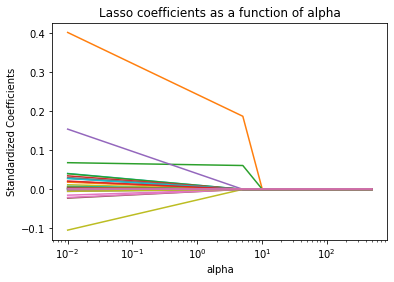

In [119]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train['target1'])
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');